## Thumbnail Generation Workflow

Um den Prozess abzuschließen soll für das generierte Video noch ein passendes Thumbnail generiert werden, dass eventuell etwas interessanter aussieht als einfach eine Stelle des Videos. Dafür generiert ein Sprachmodell Ideen, die dann in Function Calls und letztlich Prompts und generierte Bilder überführt werden, von denen dann die geeigneten Bilder durch das Vision Language Model ausgewählt werden.

### Imports

In [1]:
# Diffusers Models
import torch
from diffusers import FluxPipeline, FluxTransformer2DModel, GGUFQuantizationConfig
from diffusers import StableDiffusionXLPipeline

# LlamaIndex Workflow
from llama_index.core.workflow import Event, StartEvent, StopEvent, Workflow, step, Context
from llama_index.utils.workflow import draw_all_possible_flows, draw_most_recent_execution # to visualize the Workflow

# Ollama LLM
import ollama

# Typing and Structured Output Models
from typing import List
from pydantic import BaseModel

# Utility Libraries
import json
import os
from IPython.display import Image, display # for displaying generated images

### Thumbnail Generation Workflow Settings

In [2]:
# Thumbnail Generation Settings
thumbnail_generation_settings = {
    "project_name": "project-1",
    "diffusion_model": "shuttle",
    "code_llm": "qwen2.5-coder:latest",
    "vlm": "llama3.2-vision:latest",
    "debug_mode": True
}

### Utility Functions

In [3]:
# Function to initialize a quantized Shuttle Diffusion Pipeline
def initialize_shuttle_diffusion_pipeline():
    ckpt_path = "https://huggingface.co/shuttleai/shuttle-3.1-aesthetic/blob/main/gguf/shuttle-3.1-aesthetic-Q4_K_S.gguf"
    
    transformer = FluxTransformer2DModel.from_single_file(
        ckpt_path,
        quantization_config=GGUFQuantizationConfig(compute_dtype=torch.bfloat16),
        torch_dtype=torch.bfloat16
    ).to("cuda")
    
    pipe = FluxPipeline.from_pretrained(
        "shuttleai/shuttle-3.1-aesthetic",
        transformer=transformer,
        torch_dtype=torch.bfloat16
    ).to("cuda")
    
    return pipe

# Function to initialize a Stable Diffusion XL Pipeline
def initialize_sdxl_pipeline():

    pipe = StableDiffusionXLPipeline.from_pretrained(
        "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
    ).to("cuda")
    
    return pipe
    
# Initialize the pipeline
if thumbnail_generation_settings["diffusion_model"] == "shuttle":
    pipe = initialize_shuttle_diffusion_pipeline()
else:
    pipe = initialize_sdxl_pipeline()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [4]:
# Generate image tool
def generate_image(prompt: str, file_name: str):
    """
    Generates an image based on a given prompt and saves the result under the given file name
    
    Args:
    prompt: AI generated prompt to generate an image using a diffusion model
    file_name: Name used to save the generated without file extension
    
    Returns:
    str: The whole path where the image file was saved
    """
    output_dir = "/home/ubuntu/thumbnails/" + thumbnail_generation_settings["project_name"]
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    if thumbnail_generation_settings["diffusion_model"] == "shuttle":
        num_inference_steps = 4
    else:
        num_inference_steps = 50
    height = 288
    width = 512
    image = pipe(
        prompt,
        height=height,
        width=width,
        guidance_scale=10.0,
        num_inference_steps=num_inference_steps,
        generator=torch.manual_seed(42)
    ).images[0]
    file_path = output_dir + "/" + file_name + ".png"
    image.save(file_path)
    return file_path

In [5]:
# Ollama LLM Utility Function with optional image input, function calling and structured output generation
def call_ollama_model(
    model="qwen2.5-coder:latest",
    system_prompt=None,
    user_prompt=None,
    temperature=0.1,
    context_size=16384,
    images=None,
    tools=None,
    json_schema=None
):
    response = ollama.chat(
        model=model,
        messages=[
            {
                "role": "system",
                "content": system_prompt
            },
            {
                "role": "user",
                "content": user_prompt,
                "images": images
            }
        ],
        options={
            "temperature": temperature,
            "num_ctx": context_size
        },
        format=json_schema,
        tools=tools
    )
    
    return response.message

### Model and Event Definition

In [6]:
# Model for structured output generation of thumbnail ideas
class ThumbnailIdeas(BaseModel):
    thumbnail_ideas: List[str]

# Model for structured output generation of image suitability as thumbnail
class ImageSuitability(BaseModel):
    is_suitable: bool
    explanation: str

# Event that thumbnail ideas are generated
class ThumbnailIdeasGeneratedEvent(Event):
    thumbnail_ideas: ThumbnailIdeas

# Event that images were generated
class ImagesGeneratedEvent(Event):
    image_paths: List[str]

In [7]:
# Custom prompts for thumbnail generation workflow
import thumbnail_prompts

In [8]:
# Example system prompt
thumbnail_system_prompts = thumbnail_prompts.SystemPrompts()
print(thumbnail_system_prompts.THUMBNAIL_IDEA_GENERATION)


You are a professional educational YouTuber specializing in mathematical content, with over 1 million subscribers.
Your expertise includes:
- Creating visually engaging thumbnails that capture viewer attention
- Understanding what drives click-through rates in educational content
- Balancing academic rigor with visual appeal

Guidelines for thumbnail ideation:
1. Incorporate symbolic or historical elements related to mathematics
2. Use visual metaphors that connect abstract concepts to tangible objects
3. Consider incorporating:
   - Historical mathematicians' portraits or busts
   - Mathematical symbols and diagrams
   - Visual paradoxes or optical illusions
   - Sacred geometry patterns
   - Real-world applications of mathematical concepts

Avoid:
- Overly complex mathematical notation
- Direct representation of video content
- Generic stock photos without mathematical significance
- Clickbait that misrepresents the content



In [9]:
# Example user prompt
thumbnail_user_prompts = thumbnail_prompts.UserPrompts()
print(thumbnail_user_prompts.THUMBNAIL_IDEA_GENERATION)


Generate a list of {num_thumbnails} thumbnail ideas on the following topic and video plan:

Topic: {topic}

Video plan: {video_plan}



In [10]:
# Example user prompt params
user_prompts = thumbnail_prompts.UserPrompts()
print(user_prompts.get_params("THUMBNAIL_IDEA_GENERATION"))

['num_thumbnails', 'topic', 'video_plan']


In [11]:
class ThumbnailGenerationFlow(Workflow):
    @step
    async def generate_thumbnail_ideas(
        self, ctx: Context, ev: StartEvent
    ) -> ThumbnailIdeasGeneratedEvent:
        # Get input and settings from StartEvent
        topic = ev.topic
        video_plan = ev.video_plan
        num_thumbnails = ev.num_thumbnails

        settings = ev.settings
        code_llm = settings.get("code_llm", "qwen2.5-coder:latest")
        vlm = settings.get("vlm", "llama3.2-vision:latest")
        debug_mode = settings.get("debug_mode", False)

        # Set initial global context
        await ctx.set("code_llm", code_llm)
        await ctx.set("vlm", vlm)
        await ctx.set("debug_mode", debug_mode)

        system_prompt = thumbnail_system_prompts.THUMBNAIL_IDEA_GENERATION
        user_prompt = thumbnail_user_prompts.THUMBNAIL_IDEA_GENERATION.format(
            num_thumbnails=num_thumbnails, topic=topic, video_plan=video_plan
        )

        response_msg = call_ollama_model(
            model=vlm,
            system_prompt=system_prompt,
            user_prompt=user_prompt,
            images=None,
            temperature=0.1,
            context_size=16384,
            json_schema=ThumbnailIdeas.model_json_schema(),
        )

        # Try to parse the generated JSON response
        try:
            thumbnail_ideas = json.loads(response_msg.content)
        except:
            thumbnail_ideas = ThumbnailIdeas(thumbnail_ideas=[])

        if debug_mode:
            print(thumbnail_ideas)
            
        return ThumbnailIdeasGeneratedEvent(thumbnail_ideas=thumbnail_ideas)

    @step
    async def generate_images(
        self, ctx: Context, ev: ThumbnailIdeasGeneratedEvent
    ) -> ImagesGeneratedEvent:
        # Get input and settings from ThumbnailIdeasGeneratedEvent
        thumbnail_ideas = ev.thumbnail_ideas

        # Get relevant data from global context
        code_llm = await ctx.get("code_llm")
        debug_mode = await ctx.get("debug_mode")

        # Get the list of thumbnail ideas and turn it into a string as context
        thumbnail_ideas_list = thumbnail_ideas.thumbnail_ideas
        thumbnail_ideas_str = "\n\n".join(thumbnail_ideas_list)

        system_prompt = thumbnail_system_prompts.IMAGE_GENERATION_FUNCTION_CALLING
        user_prompt = thumbnail_user_prompts.IMAGE_GENERATION_FUNCTION_CALLING.format(
            thumbnail_ideas_str=thumbnail_ideas_str
        )

        response_msg = call_ollama_model(
            model=code_llm,
            system_prompt=system_prompt,
            user_prompt=user_prompt,
            images=None,
            temperature=0.1,
            context_size=16384,
            tools=[generate_image],
        )

        available_functions = {
            "generate_image": generate_image,
        }

        image_paths = []

        # Gerate images via function call
        for tool in response_msg.tool_calls or []:
            function_to_call = available_functions.get(tool.function.name)
            if function_to_call:
                arguments = tool.function.arguments
                file_path = function_to_call(**arguments)
                image_paths.append(file_path)

                if debug_mode:
                    print("Prompt: ", arguments.get("prompt", ""))
                    print("Function output:", file_path)
                    display(Image(filename=file_path))
            else:
                print("Function not found:", tool.function.name)

        return ImagesGeneratedEvent(image_paths=image_paths)

    @step
    async def evaluate_images(
        self, ctx: Context, ev: ImagesGeneratedEvent
    ) -> StopEvent:
        # Get input and settings from StartEvent
        image_paths = ev.image_paths

        # Get relevant data from global context
        debug_mode = await ctx.get("debug_mode")
        vlm = await ctx.get("vlm")

        system_prompt = thumbnail_system_prompts.THUMBNAIL_EVALUATION
        user_prompt = thumbnail_user_prompts.THUMBNAIL_EVALUATION

        suitable_images = []

        # Check image suitability as thumbnail (one by one as Llama3.2 Vision only takes 1 image at a time in Ollama)
        for image_path in image_paths:
            response_msg = call_ollama_model(
                model=vlm,
                system_prompt=system_prompt,
                user_prompt=user_prompt,
                images=[image_path],
                temperature=0.1,
                context_size=16384,
                json_schema=ImageSuitability.model_json_schema(),
            )

            image_suitability = json.loads(response_msg.content)
            is_suitable = image_suitability.get("is_suitable", False)

            if debug_mode:
                print("Thumbnail is suitable: ", str(is_suitable))
                print(image_suitability["explanation"])

            if is_suitable:
                suitable_images.append(image_path)

        return StopEvent(result=suitable_images)

In [12]:
EXAMPLE_PLAN = """1. **Create Grid**: Draw a coordinate system on paper or screen. Mark the x and y axes for orientation. The grid should be large enough to display all given points.

2. **Mark Points**:
   - **Point A**: Locate (1, 1) on the coordinate system. Move 1 unit along the x-axis from the origin to the right and then 1 unit up along the y-axis. Mark this point as A.
   - **Point B**: Find (5, 1) on the coordinate system. Move 5 units along the x-axis from the origin to the right and stay at the same height (y=1). Mark this point as B.
   - **Point C**: Find (3, 4) on the coordinate system. Move 3 units along the x-axis from the origin to the right and then 4 units up along the y-axis. Mark this point as C.

3. **Label Points**: Label each marked point with its corresponding letter to clearly identify them: Label the point at (1, 1) as A, at (5, 1) as B, and at (3, 4) as C.

4. **Draw Lines**:
   - Connect Point A and Point B with a straight line.
   - Connect Point B and Point C with a straight line.
   - Connect Point C and Point A with a straight line.

5. **Verification**:
   - Verify that each triangle segment is drawn correctly: AB horizontal (y-coordinates equal), AC and BC diagonal in their respective directions based on their x and y coordinates.

6. **Summary**: You should now have a closed triangle, labeled with A(1, 1), B(5, 1), and C(3, 4), within your coordinate system."""

In [13]:
thumbnail_generation_flow = ThumbnailGenerationFlow(timeout=None, verbose=True)

thumbnail_generation_ctx = Context(thumbnail_generation_flow)

draw_all_possible_flows(ThumbnailGenerationFlow, filename="Pipeline-Visualizations/thumbnail_generation_flow.html")

<class 'NoneType'>
<class 'llama_index.core.workflow.events.StopEvent'>
<class '__main__.ImagesGeneratedEvent'>
<class '__main__.ThumbnailIdeasGeneratedEvent'>
thumbnail_generation_flow.html


Running step generate_thumbnail_ideas
{'thumbnail_ideas': ['A stylized illustration of the ancient Greek philosopher Pythagoras holding a tablet with the equation a^2 + b^2 = c^2 inscribed on it. In the background, a subtle grid pattern hints at the mathematical concepts to be explored.', "A visual representation of the three points A(1, 1), B(5, 1), and C(3, 4) as a stylized puzzle piece, with each point connected by lines forming a triangle. The title 'Pythagorean Theorem' is written in bold, geometric font.", 'A portrait of Pythagoras surrounded by intricate geometric patterns inspired by sacred geometry, with the equation a^2 + b^2 = c^2 subtly integrated into the design. In the foreground, a small grid and three points A, B, and C are visible, hinting at the mathematical concepts to be explored.']}
Step generate_thumbnail_ideas produced event ThumbnailIdeasGeneratedEvent
Running step generate_images


  0%|          | 0/4 [00:00<?, ?it/s]

Prompt:  A stylized illustration of the ancient Greek philosopher Pythagoras holding a tablet with the equation a^2 + b^2 = c^2 inscribed on it. In the background, a subtle grid pattern hints at the mathematical concepts to be explored.
Function output: /home/ubuntu/thumbnails/project-1/pythagoras_tablet.png


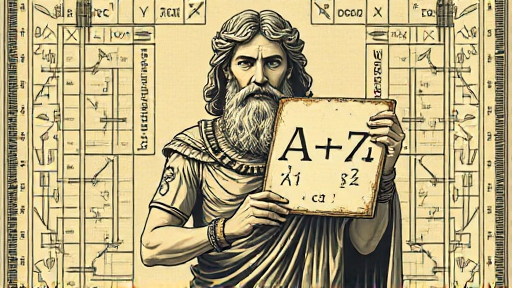

  0%|          | 0/4 [00:00<?, ?it/s]

Prompt:  A visual representation of the three points A(1, 1), B(5, 1), and C(3, 4) as a stylized puzzle piece, with each point connected by lines forming a triangle. The title 'Pythagorean Theorem' is written in bold, geometric font.
Function output: /home/ubuntu/thumbnails/project-1/pythagorean_triangle.png


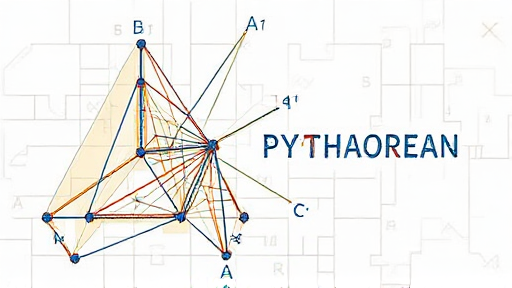

  0%|          | 0/4 [00:00<?, ?it/s]

Prompt:  A portrait of Pythagoras surrounded by intricate geometric patterns inspired by sacred geometry, with the equation a^2 + b^2 = c^2 subtly integrated into the design. In the foreground, a small grid and three points A, B, and C are visible, hinting at the mathematical concepts to be explored.
Function output: /home/ubuntu/thumbnails/project-1/pythagoras_portrait.png


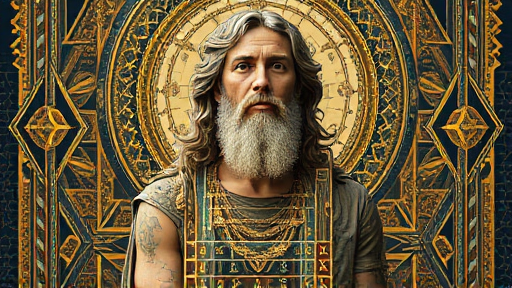

Step generate_images produced event ImagesGeneratedEvent
Running step evaluate_images
Thumbnail is suitable:  False
The image does not meet the evaluation criteria for a YouTube thumbnail. It lacks visual impact, technical quality, content alignment, and performance indicators.
Thumbnail is suitable:  False
The image does not meet the evaluation criteria for a YouTube thumbnail. It lacks visual impact, technical quality, content alignment, and performance indicators.
Thumbnail is suitable:  True
The image features an older man with long hair and a beard, dressed in ancient attire. The background is a gold circle with intricate designs, which may evoke a sense of mysticism or spirituality. This combination could be effective for a thumbnail as it immediately captures the viewer's attention and suggests that the video will explore themes related to history, culture, or personal growth.
Step evaluate_images produced event StopEvent
thumbnail_generation_last_execution.html


In [14]:
result = await thumbnail_generation_flow.run(topic="Pythagorean Theorem", video_plan=EXAMPLE_PLAN, num_thumbnails=3, settings=thumbnail_generation_settings)

draw_most_recent_execution(thumbnail_generation_flow, filename="Pipeline-Visualizations/thumbnail_generation_last_execution.html")

In [15]:
result

['/home/ubuntu/thumbnails/project-1/pythagoras_portrait.png']